In [53]:
import yfinance as yf
import requests
import bs4 as bs
import datetime as dt
import pandas as pd
import io
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid', context='talk', palette='Dark2')

from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next I will read the file in from my local desktop

In [2]:
uploaded = files.upload()

Saving weeklytarget2020_062023.csv to weeklytarget2020_062023.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['weeklytarget2020_062023.csv']))
print(df)

       Unnamed: 0        Date Symbol   Adj Close       Close        High  \
0               0  2020-01-06      A   85.549843   87.589996   88.239998   
1             496  2020-01-13      A   88.020920   90.120003   90.279999   
2             992  2020-01-20      A   86.204247   88.260002   90.639999   
3            1488  2020-01-27      A   80.637009   82.559998   88.360001   
4            1984  2020-02-03      A   81.232803   83.169998   85.500000   
...           ...         ...    ...         ...         ...         ...   
90828       88828  2023-05-29    ZTS  171.502838  171.880005  172.470001   
90829       89329  2023-06-05    ZTS  162.732117  163.089996  172.660004   
90830       89830  2023-06-12    ZTS  170.365326  170.740005  172.970001   
90831       90331  2023-06-19    ZTS  168.000519  168.369995  171.149994   
90832       90832  2023-06-26    ZTS  171.832108  172.210007  174.679993   

              Low        Open      Volume  
0       83.599998   84.000000   8855200.0  

In [4]:
df.dtypes

Unnamed: 0      int64
Date           object
Symbol         object
Adj Close     float64
Close         float64
High          float64
Low           float64
Open          float64
Volume        float64
dtype: object

In [5]:
def process_data(df):
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.drop('Unnamed: 0',axis=1)

  return df


In [6]:
df = process_data(df)
print(df.dtypes)
print(df.columns)

Date         datetime64[ns]
Symbol               object
Adj Close           float64
Close               float64
High                float64
Low                 float64
Open                float64
Volume              float64
dtype: object
Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open',
       'Volume'],
      dtype='object')


Check the dataframe for missing values. We have none which is great news.

In [7]:
df.isna().sum()

Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

Here I will create my target variable and other momentum variables. The target variable will be binary 1/0 indicating whether or not the equity increased on a weekly basis. For these purposes that will be defined as the difference between the opening price the following Monday, and the opening price on the previous Monday.

In [8]:
def create_target(df):
  df['weekly_price_change'] = df.groupby('Symbol')['Open'].diff()
  df['target'] = np.where(df['weekly_price_change'].shift(-1) >= 0 ,1,0)
  return df


In [9]:
df = create_target(df)


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,weekly_price_change,target
0,2020-01-06,A,85.549843,87.589996,88.239998,83.599998,84.000000,8855200.0,NaN,1
1,2020-01-13,A,88.020920,90.120003,90.279999,86.699997,87.809998,10250000.0,3.809998,1
2,2020-01-20,A,86.204247,88.260002,90.639999,87.580002,89.800003,6756000.0,1.990005,0
3,2020-01-27,A,80.637009,82.559998,88.360001,82.339996,86.540001,10528800.0,-3.260002,0
4,2020-02-03,A,81.232803,83.169998,85.500000,82.110001,83.290001,8224000.0,-3.250000,0


Over this time frame, our target variable has a mean of .53, which means that 53% of the data saw a week over week increase in prices.

In [12]:
df['target'].describe()

count    90833.000000
mean         0.533573
std          0.498874
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: target, dtype: float64

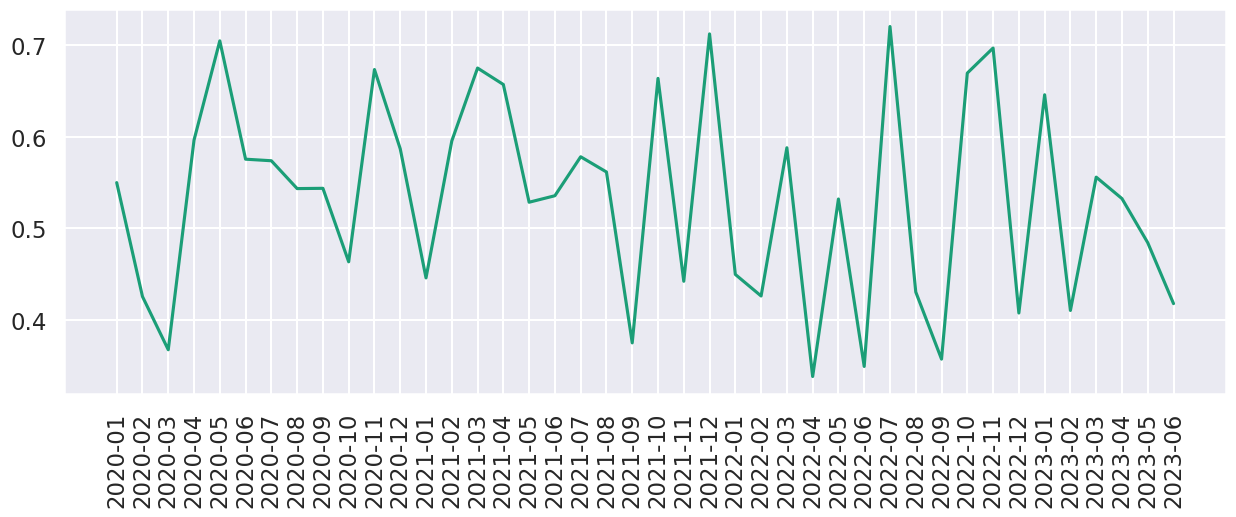

In [27]:
monthly_target_avg = df.groupby(pd.PeriodIndex(df['Date'], freq="M"))['target'].mean().reset_index()

plt.figure(figsize=(15,5))
plt.plot(monthly_target_avg["Date"].astype('str'), monthly_target_avg["target"], label = 'avg')
plt.xticks(rotation=90)
plt.show()


In [35]:
mta = pd.DataFrame(monthly_target_avg)
mta['mon_int'] = mta['Date'].dt.month
print(np.corrcoef(mta['mon_int'],mta['target']))

[[1.         0.17127937]
 [0.17127937 1.        ]]


At least globally, there appears to be very little reason to include a month variable to control for any type of seasonality.

Now I am going to create various momentum features.
https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/



In [36]:
def momentum_features(df):
  df['2wk_open_avg'] = df.groupby('Symbol')['Open'].rolling(2).mean().reset_index(level=0,drop=True)
  df['ema_2wk'] = df.groupby('Symbol')['Open'].ewm(span=2, adjust=False).mean().reset_index(level=0,drop=True)
  df['4wk_open_avg'] = df.groupby('Symbol')['Open'].rolling(4).mean().reset_index(level=0,drop=True)
  df['ema_4wk'] = df.groupby('Symbol')['Open'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)
  df['6wk_open_avg'] = df.groupby('Symbol')['Open'].rolling(6).mean().reset_index(level=0,drop=True)
  df['ema_6wk'] = df.groupby('Symbol')['Open'].ewm(span=6, adjust=False).mean().reset_index(level=0,drop=True)

  df['2wk_vol_avg'] = df.groupby('Symbol')['Volume'].rolling(2).mean().reset_index(level=0,drop=True)
  df['ema_vol2wk'] = df.groupby('Symbol')['Volume'].ewm(span=2, adjust=False).mean().reset_index(level=0,drop=True)
  df['4wk_vol_avg'] = df.groupby('Symbol')['Volume'].rolling(4).mean().reset_index(level=0,drop=True)
  df['ema_vol4wk'] = df.groupby('Symbol')['Volume'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)
  df['6wk_vol_avg'] = df.groupby('Symbol')['Volume'].rolling(6).mean().reset_index(level=0,drop=True)
  df['ema_vol6wk'] = df.groupby('Symbol')['Volume'].ewm(span=6, adjust=False).mean().reset_index(level=0,drop=True)

  df['ema_9wk'] = df.groupby('Symbol')['Open'].ewm(span=9, adjust=False).mean().reset_index(level=0,drop=True)
  df['MACD_9_4'] = df['ema_4wk'] - df['ema_9wk']
  df['MACD_signal_9_4'] = df.groupby('Symbol')['MACD_9_4'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)

  df['ema_12wk'] = df.groupby('Symbol')['Open'].ewm(span=12, adjust=False).mean().reset_index(level=0,drop=True)
  df['MACD_12_6'] = df['ema_12wk'] - df['ema_6wk']
  df['MACD_signal_12-6'] = df.groupby('Symbol')['MACD_12_6'].ewm(span=4, adjust=False).mean().reset_index(level=0,drop=True)

  return df





In [38]:
df = momentum_features(df)
df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,weekly_price_change,target,...,4wk_vol_avg,ema_vol4wk,6wk_vol_avg,ema_vol6wk,ema_9wk,MACD_9_4,MACD_signal_9_4,ema_12wk,MACD_12_6,MACD_signal_12-6
0,2020-01-06,A,85.549843,87.589996,88.239998,83.599998,84.000000,8855200.0,NaN,1,...,NaN,8855200.00,NaN,8.855200e+06,84.000000,0.00000,0.000000,84.000000,0.000000,0.000000
1,2020-01-13,A,88.020920,90.120003,90.279999,86.699997,87.809998,10250000.0,3.809998,1,...,NaN,9413120.00,NaN,9.253714e+06,84.762000,0.76200,0.304800,84.586153,-0.502417,-0.200967
2,2020-01-20,A,86.204247,88.260002,90.639999,87.580002,89.800003,6756000.0,1.990005,0,...,NaN,8350272.00,NaN,8.540082e+06,85.769600,1.46480,0.768800,85.388284,-1.046410,-0.539144
3,2020-01-27,A,80.637009,82.559998,88.360001,82.339996,86.540001,10528800.0,-3.260002,0,...,9097500.0,9221683.20,NaN,9.108287e+06,85.923680,1.03296,0.874464,85.565471,-0.899311,-0.683211
4,2020-02-03,A,81.232803,83.169998,85.500000,82.110001,83.290001,8224000.0,-3.250000,0,...,8939700.0,8822609.92,NaN,8.855633e+06,85.396944,0.09304,0.561895,85.215399,-0.342303,-0.546847


In [48]:
d = df.iloc[ : , 6:]
corr = d.corr()
corr.style.background_gradient(cmap='coolwarm')
#sns.heatmap(corr, annot=True)
#plt.show()

,Open,Volume,weekly_price_change,target,2wk_open_avg,ema_2wk,4wk_open_avg,ema_4wk,6wk_open_avg,ema_6wk,2wk_vol_avg,ema_vol2wk,4wk_vol_avg,ema_vol4wk,6wk_vol_avg,ema_vol6wk,ema_9wk,MACD_9_4,MACD_signal_9_4,ema_12wk,MACD_12_6,MACD_signal_12-6
Open,1.000000,-0.106623,0.080686,-0.003876,0.999653,0.999837,0.998891,0.999315,0.998138,0.998790,-0.108761,-0.108765,-0.110640,-0.110137,-0.111724,-0.110587,0.998038,0.275798,0.296753,0.997315,-0.317740,-0.329003
Volume,-0.106623,1.000000,-0.005045,-0.011559,-0.106918,-0.106686,-0.107388,-0.106773,-0.108923,-0.106848,0.981626,0.993142,0.960612,0.978157,0.951915,0.968216,-0.106943,-0.020132,-0.022159,-0.107017,0.023996,0.025406
weekly_price_change,0.080686,-0.005045,1.000000,-0.002052,0.054402,0.063672,0.042320,0.050979,0.041009,0.046039,-0.004410,-0.004137,-0.001742,-0.002561,-0.000664,-0.001652,0.042673,0.265223,0.094127,0.041005,-0.166323,-0.055274
target,-0.003876,-0.011559,-0.002052,1.000000,-0.003931,-0.003831,-0.003986,-0.003606,-0.003369,-0.003351,-0.004845,-0.007093,-0.000762,-0.003296,-0.000156,-0.001684,-0.003063,-0.017421,-0.016699,-0.002876,0.015446,0.012792
2wk_open_avg,0.999653,-0.106918,0.054402,-0.003931,1.000000,0.999939,0.999532,0.999749,0.998865,0.999352,-0.108839,-0.109113,-0.110789,-0.110545,-0.111909,-0.111027,0.998685,0.269728,0.295276,0.998003,-0.314428,-0.328664
ema_2wk,0.999837,-0.106686,0.063672,-0.003831,0.999939,1.000000,0.999536,0.999782,0.998916,0.999398,-0.108841,-0.108851,-0.110782,-0.110263,-0.111906,-0.110739,0.998752,0.268392,0.293449,0.998085,-0.312941,-0.327105
4wk_open_avg,0.998891,-0.107388,0.042320,-0.003986,0.999532,0.999536,1.000000,0.999908,0.999715,0.999827,-0.109396,-0.109676,-0.110960,-0.111237,-0.112173,-0.111796,0.999419,0.252425,0.285821,0.998880,-0.302701,-0.323135
ema_4wk,0.999315,-0.106773,0.050979,-0.003606,0.999749,0.999782,0.999908,1.000000,0.999654,0.999890,-0.108938,-0.108959,-0.110948,-0.110425,-0.112141,-0.110944,0.999498,0.252315,0.282280,0.998989,-0.300492,-0.318982
6wk_open_avg,0.998138,-0.108923,0.041009,-0.003369,0.998865,0.998916,0.999715,0.999654,1.000000,0.999872,-0.110245,-0.110789,-0.111697,-0.112145,-0.112336,-0.112676,0.999762,0.234875,0.271636,0.999411,-0.288513,-0.312964
ema_6wk,0.998790,-0.106848,0.046039,-0.003351,0.999352,0.999398,0.999827,0.999890,0.999872,1.000000,-0.109016,-0.109043,-0.111057,-0.110539,-0.112295,-0.111089,0.999849,0.238200,0.269995,0.999510,-0.287938,-0.308738


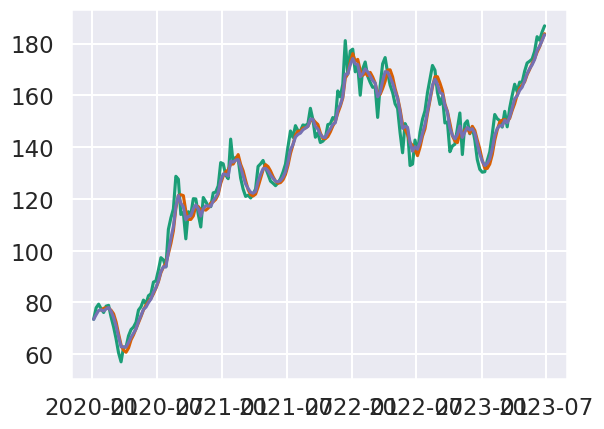

In [49]:
aapl = df[df['Symbol']=='AAPL']

plt.plot(aapl["Date"], aapl["Open"], label = 'open_price')
plt.plot(aapl["Date"], aapl["4wk_open_avg"], label = '4wk_avg')
plt.plot(aapl["Date"], aapl["ema_4wk"], label = '4wk_ema')
plt.show()

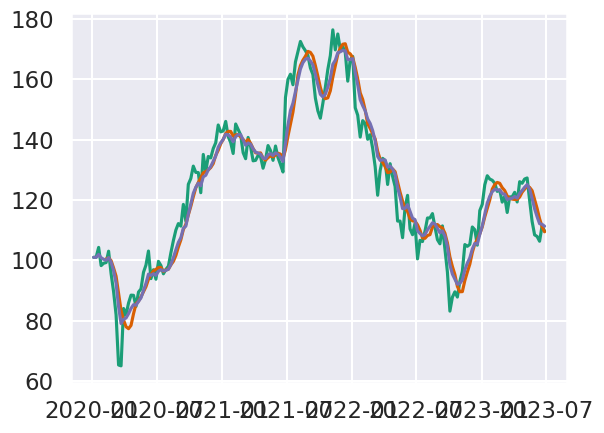

In [50]:
NKE = df[df['Symbol']=='NKE']

plt.plot(NKE["Date"], NKE["Open"], label = 'open_price')
plt.plot(NKE["Date"], NKE["6wk_open_avg"], label = '6wk_avg')
plt.plot(NKE["Date"], NKE["ema_6wk"], label = '6wk_ema')
plt.show()

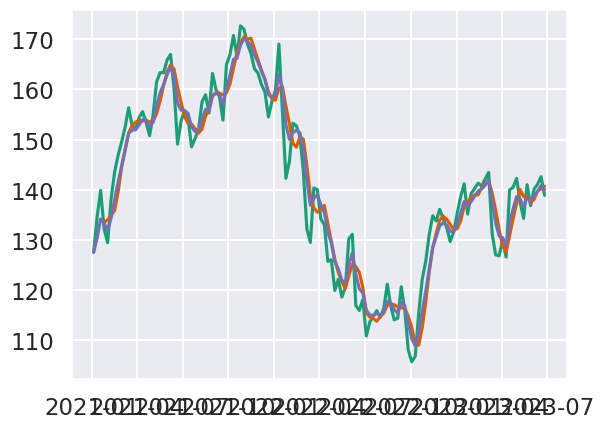

In [13]:
jpm= df[df['Symbol']=='JPM']

plt.plot(jpm["Date"], jpm["Open"], label = 'open_price')
plt.plot(jpm["Date"], jpm["rolling_4wk_open_avg"], label = '4wk_avg')
plt.plot(jpm["Date"], jpm["ema_4wk"], label = '4wk_ema')
plt.show()

Drop NaNs and one hot encode our ticker symbols

In [51]:
def one_hot(df):
  encoder=OneHotEncoder(sparse=False)

  df_encoded = pd.DataFrame(encoder.fit_transform(df[['Symbol']]))

  df_encoded.columns = encoder.get_feature_names_out(['Symbol'])

  oh_df = pd.concat([df, df_encoded], axis=1)
  oh_df = oh_df.dropna()
  return oh_df


In [54]:
ohdf = one_hot(df)
ohdf.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,weekly_price_change,target,...,Symbol_WYNN,Symbol_XEL,Symbol_XOM,Symbol_XRAY,Symbol_XYL,Symbol_YUM,Symbol_ZBH,Symbol_ZBRA,Symbol_ZION,Symbol_ZTS
5,2020-02-10,A,83.821075,85.820000,86.059998,82.930000,83.040001,8636000.0,-0.250000,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2020-02-17,A,83.088547,85.070000,86.080002,83.360001,85.660004,11919900.0,2.620003,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2020-02-24,A,75.274902,77.070000,82.589996,74.169998,82.220001,14848200.0,-3.440002,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2020-03-02,A,76.730186,78.559998,85.000000,76.500000,77.309998,13612500.0,-4.910004,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2020-03-09,A,67.588188,69.199997,74.190002,62.160000,72.589996,21437600.0,-4.720001,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
ohdf.to_csv('momentum_target070123.csv')